# Introduction

Vehicle electrification is widely regarded as a critical tool for climate change mitigation in the transportation sector [@musti2011]. While the United States is seeing an increasing share of electric sales, the pace of adoption remains well below the necessary level to mitigate climate change impacts. One barrier to widespread adoption is the lack of charging infrastructure [@sullivan2021].

A common policy put forward to increase electric vehicle adoption is a federal income tax credit for EV buyers. However, spending similar amounts on increasing deployment of charging stations could yield more effective results [@Li2017]. This is especially the case in the early stages of EV market penetration; EV markets that have critical-mass constraints have the most success in increasing market penetration with a subsidy policy that deals with indirect network effects [@Zhou2018]. One of the indirect network effects on the EV market comes from the charging station market.

Subsidies for charging stations are found to be most effective because of the low-price sensitivity of early EV adopters [@Li2017]. This is intuitive because early EV adopters are more eager to purchases EVs, which makes them more willing to pay for higher prices. The issue these consumers are concerned with is their ability to utilize this new technology, which is affected by the existing charging station infrastructure. Because of this, understanding consumer’s preferences for charging station infrastructure is crucial. Consumers are willing to pay about 5 cents per mile for plug-in electric vehicles and about 10 cents per minute of wait time while refueling. Consumers are also willing to wait up to 8 minutes longer during refueling [@Sheldon2019]. Knowing this information can allow policy makers to create subsidy programs that produce more effective outcomes.



In [4]:
#import geoplot as gplt
#import geopandas as gpd
#import geoplot.crs as gcrs
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#import mapclassify as mc
import numpy as np
#from geopy.geocoders import Nominatim
#from shapely.geometry import Point
import os
#from pandasql import sqldf
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime
import numpy as np
pysqldf = lambda q: sqldf(q, globals())
pd.set_option('display.max_columns', None)

# The Electric Vehicle and Charging Station Problem

Electric vehicle ownership is often referenced as exhibiting a "chicken and egg" behavior arising from the supply and demand relationship. Individual demand for electric vehicles is influenced by the available supply of charging points. Consumers are unwilling to purchase vehicles due to range anxiety and a perceived lack of charging stations. Suppliers are not incentivized to provide charging stations unless there is sufficient demand to warrant their cost. There is a clear role for public policy in such situations. The government deems electric vehicles as a solution to a public ill (i.e., climate change) and can incentivize either suppliers by providing installation subsidies or consumers by installing charging stations. While the problem has been recognized in the literature [@melliger2018], empirical analysis is minimal.

An important consideration to the analysis is how electric mobility system may differ from one based on fossil fuels. In the conventional private mobility model, the individual owns the vehicle and purchases fuel from centralized and privately owned refueling stations. In contrast, electric vehicles may be charged in the home using previously existing infrastructure. The presence of charging points in the home begs the questions 1) if (or to what extent) out-of-home charging stations are required for travel? and 2) to what extent is range anxiety a perception versus a reality?

According to the Bureau of Transportation Statistics, 98% of trips made in the US are less than 50 miles [@vehicletechnologyoffice2022]. Given that most battery-electric vehicles (BEVs) have a range greater than 200 miles [@elfalan2021], it is feasible to make most trips on a single charge. However, long-distance trips (over 50 miles) comprise 30% of total vehicle-miles traveled (VMT) [@aultman-hall2018]. There is clearly a need for out-of-home charging stations to accommodate these trips. Even if most trips can be accommodated by in-home charging, the vehicle purchase decision will be influenced by consideration of these longer trips that require charging stations [@silvia2016]. Additionally, Wolbertus et al. [@wolbertus2018] find that there is still a demand for charging stations in places where public daytime charging is the only option, such as at the workplace.

# Data Sources

We use a combination of open-source and purchased data in our analysis. The two key input datasets are charging station locations provided by the Alternative Fuel Data Center (AFDC) and electric vehicle registrations provided by Experian Inc. The vehicle registration dataset comprises a 10-year panel at 2-year increments (i.e., 2012, 2014, 2016, 2018, 2020). Total vehicle registrations are recorded by county for the United States.

This initial analysis is based on the charging station data and EV sales by state for the period 2013 to 2020 as the county-level registrations were not made available in time for publication. EV sales and market share data is provided by EVAdoption, and state population data by the U.S. Census Bureau.


In [5]:
# load charging station data
df_ch_stn = pd.read_csv("../Data/Transport/alt_fuel_stations_w_county.csv")
# filter out the private stations
print("df_ch_stn all",df_ch_stn.shape[0])
df_ch_stn = df_ch_stn[df_ch_stn["Access Code"]=="public"]
print("df_ch_stn no private",df_ch_stn.shape[0])
df_ch_stn = df_ch_stn[pd.notnull(df_ch_stn["Open Date"])]
print("df_ch_stn (after removing nan open year",df_ch_stn.shape[0])
df_ch_stn = df_ch_stn.assign(year=pd.to_datetime(df_ch_stn.loc[:,'Open Date']).dt.year.astype(int))
grp_ch_stn = df_ch_stn.groupby(["GEOID","year"]).sum()[["EVSE-L01","EVSE-L02","EVSE-L03"]].reset_index()
grp_ch_stn["cEVSE-L01"]=grp_ch_stn[["GEOID","EVSE-L01"]].groupby("GEOID").cumsum()
grp_ch_stn["cEVSE-L02"]=grp_ch_stn[["GEOID","EVSE-L02"]].groupby("GEOID").cumsum()
grp_ch_stn["cEVSE-L03"]=grp_ch_stn[["GEOID","EVSE-L03"]].groupby("GEOID").cumsum()
grp_ch_stn["cEVSE"]=grp_ch_stn["cEVSE-L01"]+grp_ch_stn["cEVSE-L02"]+grp_ch_stn["cEVSE-L03"]

# load vehicle registrations data
df_veh_reg = pd.read_parquet("../Data/Transport/Experian Registrations/sum_registrations.parquet")
# fill nan with zero and aggregate electricity columns
df_veh_reg.fillna(0, inplace=True)
df_veh_reg = df_veh_reg.assign(bev=df_veh_reg["24kw Electric~Electric"]+df_veh_reg["60kw Electric~Electric"]+df_veh_reg["85kw Electric~Electric"]+df_veh_reg["90kw Electric~Electric"]+df_veh_reg["Electric"]+df_veh_reg["Electric Fuel System"])
df_veh_reg = df_veh_reg.assign(pev=(df_veh_reg["bev"]+df_veh_reg["Plug-In Hybrid"]))
# percent bev is bev/total vehicles
df_veh_reg = df_veh_reg.assign(per_bev=df_veh_reg["bev"] / df_veh_reg["All"])
# percent pev is (bev+phev)/total vehicles
df_veh_reg = df_veh_reg.assign(per_pev=df_veh_reg["pev"] / df_veh_reg["All"])

# combine registration and charging data by year and county code
df = df_veh_reg.merge(grp_ch_stn.loc[:,["GEOID","year","cEVSE-L01","cEVSE-L02","cEVSE-L03","cEVSE"]],how="left",left_on=["GEOID","year"],right_on=["GEOID","year"])
# add additional columns for lagged charging station counts
df["lag_year"] = df.year-1
df = df.merge(grp_ch_stn.loc[:,["GEOID","year","cEVSE-L01","cEVSE-L02","cEVSE-L03","cEVSE"]],how="left",left_on=["GEOID","lag_year"],right_on=["GEOID","year"],suffixes=("","_lag"))
df["GEOID"] = df["GEOID"].astype(int)

# read in demographic data by county and add to main dataframe
df_pop11 = pd.read_csv("../Data/Census/county_pop_race_age_2011_2015.csv")
df_pop15 = pd.read_csv("../Data/Census/county_pop_race_age_2015_2019.csv")

# read in egrid data and add to main dataframe


# join demographics to main dataframe for 2011 to 2015
df11 = df.loc[df.year<2015,:].merge(df_pop11, how="left", left_on="GEOID", right_on="GEOID")
# update data for years 2015 forward to use the 2015-2019 data
df15 = df.loc[df.year>=2015,:].merge(df_pop15, how="left", left_on="GEOID", right_on="GEOID")
df = pd.concat((df11,df15),axis=0)
# some data are assigned county codes that don't appear in the population dataset. They should be removed for analysis.
df.dropna(axis=0,subset="ALUBE001", inplace=True)

# calculate per capita statistics (per 100,000 inhabitants)
df["bev_cap"] = (df["bev"]/df["ALUBE001"])*100000
df["pev_cap"] = (df["pev"]/df["ALUBE001"])*100000
df["cEVSE-L01_cap"] = (df["cEVSE-L01"]/df["ALUBE001"])*100000
df["cEVSE_L02_cap"] = (df["cEVSE-L02"]/df["ALUBE001"])*100000
df["cEVSE_L03_cap"] = (df["cEVSE-L03"]/df["ALUBE001"])*100000
df["cEVSE_cap"] = (df["cEVSE"]/df["ALUBE001"])*100000

df.fillna(0,inplace=True) # careful using a blanket fillna statement on a dataframe

C:\Users\naldridge2\AppData\Local\Temp\ipykernel_396\83270942.py:2: DtypeWarning: Columns (6,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ch_stn = pd.read_csv("../Data/Transport/alt_fuel_stations_w_county.csv")


df_ch_stn all 53684
df_ch_stn no private 49852
df_ch_stn (after removing nan open year 49846


TO DO: - create county-specific Granger causality statistics - Input demographic data by county - create generalized propensity scores - create regression inputs - run regressions - write literature review - write results and discussion - get casey's stuff working in the paper - write up methods - What about spatial autocorrelation and spatial spillovers

# Methods

# Results


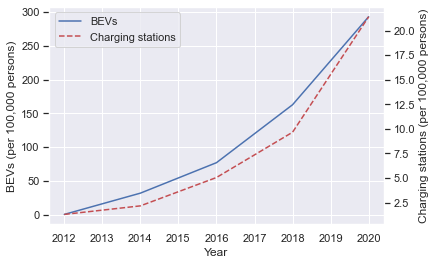

In [6]:
#| layout-ncol: 1
#| fig-cap: 
#|   - "US BEV Registrations and Charging Stations"
sns.set_theme()
us_tot = df.groupby("year").sum().reset_index()
us_tot["bev_cap"] = (us_tot["bev"]/us_tot["ALUBE001"])*100000
us_tot["cEVSE_cap"] = ((us_tot["cEVSE-L01"]+us_tot["cEVSE-L02"]+us_tot["cEVSE-L03"])/us_tot["ALUBE001"])*100000

fig, ax = plt.subplots()
x = us_tot.year
y1 = us_tot.bev_cap
y2 = us_tot.cEVSE_cap

ax2 = ax.twinx()
ln1 = ax.plot(x, y1, '-b', label='BEVs')
ln2 = ax2.plot(x,y2, '--r', label="Charging stations")
ax.set_xlabel('Year')
ax.set_ylabel('BEVs (per 100,000 persons)')
ax2.set_ylabel('Charging stations (per 100,000 persons)')
ax2.grid(False)
lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='upper left', frameon=True);

plt.show()

In [7]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

def adf_test(df):
    result = adfuller(df.values)
    print('ADF Statistics: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    
def kpss_test(df):    
    statistic, p_value, n_lags, critical_values = kpss(df.values)
    
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
        
print('ADF Test: BEV time series')
adf_test(us_tot['bev_cap'])
print('ADF Test: cEVSE_cap time series')
adf_test(us_tot['cEVSE_cap'])
        
print('KPSS Test: BEV time series')
kpss_test(us_tot['bev_cap'])
print('KPSS Test: cEVSE_cap time series')
kpss_test(us_tot['cEVSE_cap'])

ADF Test: BEV time series
ADF Statistics: 11.817204
p-value: 1.000000
Critical values:
	1%: -7.355
	5%: -4.474
	10%: -3.127
ADF Test: cEVSE_cap time series
ADF Statistics: 8.272277
p-value: 1.000000
Critical values:
	1%: -7.355
	5%: -4.474
	10%: -3.127
KPSS Test: BEV time series
KPSS Statistic: 0.36273395053087387
p-value: 0.09321812477117505
num lags: 1
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
KPSS Test: cEVSE_cap time series
KPSS Statistic: 0.45230088247588107
p-value: 0.05461168858798231
num lags: 0
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


Both ADF and KPSS tests indicate that the BEV and charging station data are non-stationary. Therefore, we will difference the data, as required by the Granger causality test.


In [ ]:
us_tot_diff = us_tot.diff().dropna()
print('ADF Test: BEV transformed time series')
adf_test(us_tot_diff['bev_cap'])
print('ADF Test: cEVSE_cap transformed time series')
adf_test(us_tot_diff['cEVSE_cap'])

The differences didn't help and we don't have a long enough time series to use a longer lag. Let's take a look at it by state.


In [ ]:
# # Neither time series is stationary for any state
# state_list = pd.unique(df.STATE)
# 
# for st in state_list:
#   st_tot = df[df.STATE==st].groupby("year").sum().reset_index()
#   st_tot["bev_cap"] = (st_tot["bev"]/st_tot["ALUBE001"])*100000
#   st_tot["cEVSE_cap"] = ((st_tot["cEVSE-L01"]+st_tot["cEVSE-L02"]+st_tot["cEVSE-L03"])/st_tot["ALUBE001"])*100000
#   #print('ADF Test: BEV time series for {0}'.format(st))
#   adf_test(st_tot['bev_cap']);
#   #print('ADF Test: cEVSE_cap time series for {0}'.format(st))
#   adf_test(st_tot['cEVSE_cap']);

Let's try a non-linear causality analysis from Rosol et al.


In [ ]:
from nonlincausality.nonlincausality import nonlincausalityMLP, nonlincausalityGRU, nonlincausalityLSTM, nonlincausalityNN, nonlincausalityARIMA

lags = 4 # number of years - 1

cty_list = pd.unique(df.GEOID)
train_cty, test_cty = np.split(cty_list, [int(len(cty_list)*0.7)])
data_train = df.loc[df.GEOID.isin(train_cty),["pev_cap","cEVSE_cap"]].values
data_test = df.loc[df.GEOID.isin(test_cty),["pev_cap","cEVSE_cap"]].values

results = nonlincausalityMLP(x=data_train, maxlag=lags, Dense_layers=2, Dense_neurons=[100, 100], x_test=data_test, run=1, add_Dropout=True, Dropout_rate=0.01, epochs_num=[50, 100], learning_rate=[0.001, 0.0001], batch_size_num=128, verbose=True, plot=True)

results_ARIMA = nonlincausalityARIMA(x=data_train, maxlag=lags, x_test=data_train)

results_GRU = nonlincausalityGRU(x=data_train, maxlag=lags, GRU_layers=2, GRU_neurons=[25, 25], Dense_layers=2, Dense_neurons=[100, 100], x_test=data_test, run=3, add_Dropout=True, Dropout_rate=0.01, epochs_num=[50, 100], learning_rate=[0.001, 0.0001], batch_size_num=128, verbose=False, plot=True)

In [ ]:
# fl_df = pd.read_csv("./EVHUB/Data/registrations/fl_ev_registrations_public.csv")
# US_sf_state = gpd.read_file("./Data/GIS/cb_2020_us_state_5m/cb_2020_us_state_5m.shp")
# #Removing the outlying islands and other territories.
# US_sf_state["STATEFP"] =pd.to_numeric(US_sf_state["STATEFP"])
# US_sf_state = US_sf_state[US_sf_state['STATEFP'] < 60]
# US_sf = US_sf[US_sf['COUNTYNS'] != "01419965"]
# station_data = pd.read_csv("./Data/Transport/alt_fuel_stations.csv")
# geometry = [Point(xy) for xy in zip(station_data.Longitude, station_data.Latitude)]
# crs = {'init' :'epsg:4326'}
# station_points = gpd.GeoDataFrame(station_data, crs=crs, geometry=geometry)
# 
# station_points = gpd.sjoin(station_points, US_sf, how='left', op='within')
# 
# merged_df = pd.DataFrame(station_points)
# 
# num_stations = merged_df['COUNTYNS'].value_counts()
# num_stations = pd.DataFrame(num_stations)
# num_stations = num_stations.reset_index()
# num_stations.columns = ['COUNTYNS','Charging Stations']
# 
# final = pd.merge(US_sf, num_stations, on = 'COUNTYNS', how = 'left')
# final['Charging Stations'] = final['Charging Stations'].fillna(0)
# 
# #  https://gist.github.com/rogerallen/1583593
# us_state_to_abbrev = {
#     "Alabama": "AL",
#     "Alaska": "AK",
#     "Arizona": "AZ",
#     "Arkansas": "AR",
#     "California": "CA",
#     "Colorado": "CO",
#     "Connecticut": "CT",
#     "Delaware": "DE",
#     "Florida": "FL",
#     "Georgia": "GA",
#     "Hawaii": "HI",
#     "Idaho": "ID",
#     "Illinois": "IL",
#     "Indiana": "IN",
#     "Iowa": "IA",
#     "Kansas": "KS",
#     "Kentucky": "KY",
#     "Louisiana": "LA",
#     "Maine": "ME",
#     "Maryland": "MD",
#     "Massachusetts": "MA",
#     "Michigan": "MI",
#     "Minnesota": "MN",
#     "Mississippi": "MS",
#     "Missouri": "MO",
#     "Montana": "MT",
#     "Nebraska": "NE",
#     "Nevada": "NV",
#     "New Hampshire": "NH",
#     "New Jersey": "NJ",
#     "New Mexico": "NM",
#     "New York": "NY",
#     "North Carolina": "NC",
#     "North Dakota": "ND",
#     "Ohio": "OH",
#     "Oklahoma": "OK",
#     "Oregon": "OR",
#     "Pennsylvania": "PA",
#     "Rhode Island": "RI",
#     "South Carolina": "SC",
#     "South Dakota": "SD",
#     "Tennessee": "TN",
#     "Texas": "TX",
#     "Utah": "UT",
#     "Vermont": "VT",
#     "Virginia": "VA",
#     "Washington": "WA",
#     "West Virginia": "WV",
#     "Wisconsin": "WI",
#     "Wyoming": "WY",
#     "District of Columbia": "DC",
#     "American Samoa": "AS",
#     "Guam": "GU",
#     "Northern Mariana Islands": "MP",
#     "Puerto Rico": "PR",
#     "United States Minor Outlying Islands": "UM",
#     "U.S. Virgin Islands": "VI",
# }
# 
# egrid_state = pd.read_excel("./Data/eGrid/egrid2020_data.xlsx", sheet_name="ST20")
# 
# # Removing first row
# new_header = egrid_state.iloc[0] #grab the first row for the header
# egrid_state = egrid_state[1:] #take the data less the header row
# egrid_state.columns = new_header #set the header row as the df header
# 
# egrid_state['FIPSST'] = egrid_state['FIPSST'].astype(int)
# 
# egrid_state = US_sf_state.merge(egrid_state, left_on= "STATEFP", right_on="FIPSST", how = "left")

`{# {python} # ## Number of Charging stations per county # ax = gplt.choropleth( #   final[final['STATEFP'] == 6], #   hue = "Charging Stations", #   edgecolor='darkgrey', #   linewidth=.5, #   cmap="viridis", #   legend=True, #   projection=gcrs.AlbersEqualArea(), #   figsize = (16,16), #   zorder = 1 # ) #  # gplt.pointplot( #   station_points[station_points['STATEFP'] == 6], #   projection=gcrs.AlbersEqualArea(), #   ax = ax, #   zorder = 2, #   s = .4 # )`

# Discussion

# Conclusions

The results presented herein are preliminary and do not consider a key dataset -- vehicle registrations. We will expand our analysis to a more robust inferential study in the coming months. Our causal question is what effect public charging stations have on electric vehicle registrations at the county-level. The treatment variable is continuous over the study period. We propose three causal identification approaches. The first approach is a difference-in-differences approach that is identified off state-level investments in charging stations by year. The second approach is generalized propensity score matching using federal election results, state-level greenhouse gas (GHG) emissions factors, and demographic characteristics (e.g., racial composition, median income, and population density) as inputs to the propensity score.

The final causal inference approach, Granger causality, differs in that it focuses on the temporal phasing of charging station installations and PEV registration, whereas the other two approaches rely on Rubin's potential outcome assumption [@reich2021]. Granger causality relies on the assumption that past treatment knowledge reduces predictive uncertainty. It is a form of time series causal inference that would fit the current context well.

# 